In [1]:
import torch
from torch import nn
import os
import pandas as pd
from torchvision.io import read_image
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class DynaSet(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
    
  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = Image.open(img_path)
    # image = read_image(img_path) pytorch/vision#4181
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label
  
transforms = Compose([
  ToTensor(),
  Resize((25,25)),
  Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])
traind = DynaSet('./dataset/annot.csv', './dataset/',
                 transform=transforms,
                 target_transform=float)
traind

In [3]:
traind.img_labels[traind.img_labels["label"] == 1]

,file,label
320,pos/puttoleft1.png,1
321,pos/puttoleft2.png,1
322,pos/puttoright1.png,1
323,pos/shift0.png,1
324,pos/shift1.png,1
325,pos/shift2.png,1
326,pos/shift3.png,1
327,pos/shiftwick0.png,1
328,pos/shiftwick1.png,1
329,pos/shiftwick2.png,1


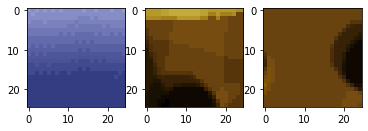

In [4]:
plt.subplot(131)
plt.imshow(np.transpose(traind[219][0].numpy()/2+.5, (1,2,0)))
plt.subplot(132)
plt.imshow(np.transpose(traind[126][0].numpy()/2+.5, (1,2,0)))
plt.subplot(133)
plt.imshow(np.transpose(traind[319][0].numpy()/2+.5, (1,2,0)))

In [5]:
trainl = DataLoader(traind, batch_size=4, shuffle=True)
trainl

In [6]:
traind.img_labels.count()

file     716
label    716
dtype: int64

In [7]:
x = iter(trainl).next()
x[1]

tensor([0., 0., 0., 0.], dtype=torch.float64)

In [8]:
class DynaNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc = nn.Sequential(
      nn.Linear(1875, 1000),
      nn.ReLU(),
      nn.Linear(1000, 500),
      nn.ReLU(),
      nn.Linear(500, 1),
    )

  def forward(self, x):
    x = self.flatten(x)
    x = self.fc(x)
    return x
DynaNet()

DynaNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=1875, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=1, bias=True)
  )
)

0/10 0.6670
0/21 0.5583
0/32 0.4964
0/43 0.4441
0/54 0.3479
0/65 0.3563
0/76 0.2851
0/87 0.2409
0/98 0.2714
0/109 0.3352
0/120 0.1815
0/131 0.1753
0/142 0.1099
0/153 0.1333
0/164 0.2546
0/175 0.3264
1/10 0.1461
1/21 0.2472
1/32 0.0962
1/43 0.2201
1/54 0.3234
1/65 0.0792
1/76 0.2968
1/87 0.2130
1/98 0.2055
1/109 0.1042
1/120 0.2170
1/131 0.0699
1/142 0.0723
1/153 0.0663
1/164 0.1115
1/175 0.1416
2/10 0.0770
2/21 0.1745
2/32 0.3064
2/43 0.1593
2/54 0.0682
2/65 0.2267
2/76 0.0960
2/87 0.1914
2/98 0.0568
2/109 0.1594
2/120 0.0950
2/131 0.2067
2/142 0.0434
2/153 0.0498
2/164 0.1629
2/175 0.0897
3/10 0.0641
3/21 0.1392
3/32 0.0443
3/43 0.0474
3/54 0.0329
3/65 0.2644
3/76 0.1669
3/87 0.0611
3/98 0.1425
3/109 0.0443
3/120 0.1511
3/131 0.1661
3/142 0.1407
3/153 0.0339
3/164 0.0766
3/175 0.1592
4/10 0.1210
4/21 0.1323
4/32 0.1313
4/43 0.1570
4/54 0.0468
4/65 0.1013
4/76 0.1266
4/87 0.0543
4/98 0.0346
4/109 0.0397
4/120 0.0274
4/131 0.0733
4/142 0.1482
4/153 0.0223
4/164 0.0238
4/175 0.1151
5/10 

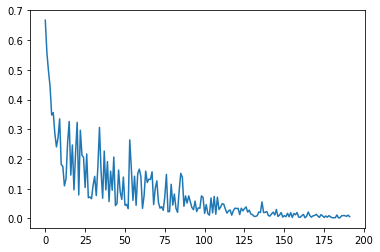

In [9]:
net = DynaNet()
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(net.parameters(), lr=1e-5)

step = 11
running_losses = []
for epoch in range(12):
  running_loss = 0.
  for i, (b, l) in enumerate(trainl):
    net.train()
    optim.zero_grad()
    y = net(b)
    loss = loss_fn(y.squeeze(), l)
    loss.backward()
    optim.step()
    running_loss += loss.item()
    if i % step == step-1:
      running_losses.append(running_loss/step)
      print(f"{epoch}/{i} {running_losses[-1]:.4f}")
      running_loss = 0.
    
plt.plot(running_losses)

(640, 800, 3)

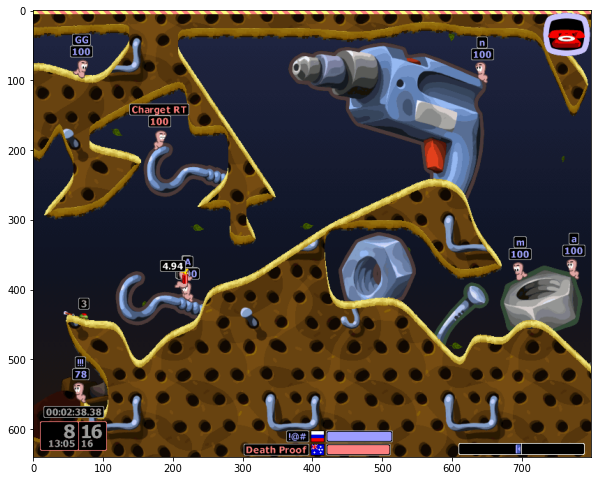

In [10]:
testimg = cv2.cvtColor(cv2.imread("./img/target.png"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(testimg)
plt.plot()
testimg.shape

In [11]:
kernel = 25
stride = 2
testd = []
for xi in range(0, len(testimg), stride):
  for yi in range(0, len(testimg[xi]), stride):
    padd = np.zeros((kernel,kernel,3), np.uint8)
    targ = testimg[xi:xi+kernel,yi:yi+kernel,:]
    s = targ.shape
    padd[:s[0], :s[1], :] = targ
    testd.append(padd)
len(testd)

128000

[]

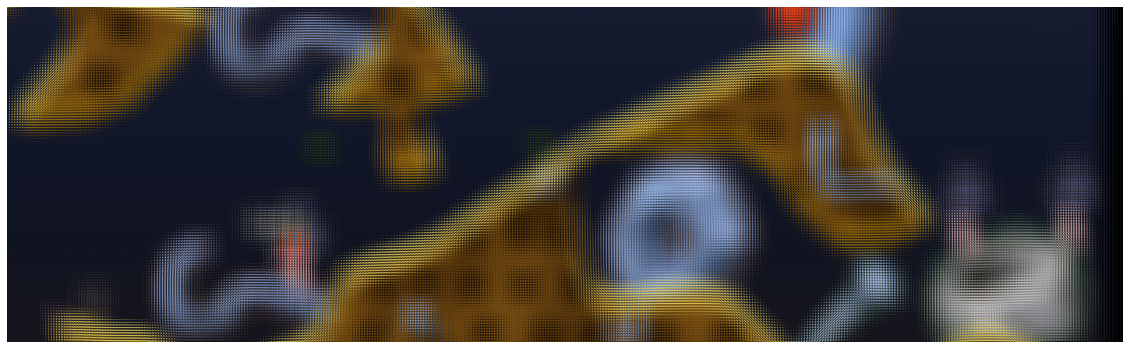

In [12]:
plt.figure(figsize=(20,20))
s = 400
plt.axis('off')
plt.imshow(np.vstack([np.concatenate(testd[i:i+s],axis=1) for i in range(40000, len(testd)-40000, s)]))
plt.plot()

(25, 25, 3)

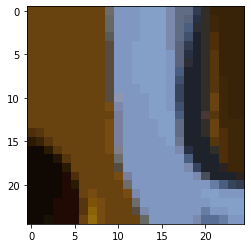

In [13]:
plt.imshow(testd[63491])
testd[63491].shape

In [14]:
rr = [None] * len(testd)
with torch.no_grad():
  for i in range(len(testd)):
    net.eval()
    r = net(transforms(testd[i]).unsqueeze(0))
    rr[i] = r

In [15]:
top = np.argsort(rr)[::-1][:400]
topim = []
for idx in top:
  topim.append(testd[idx])

/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Top 400 Matches. Can be used as training data (false positives especially).

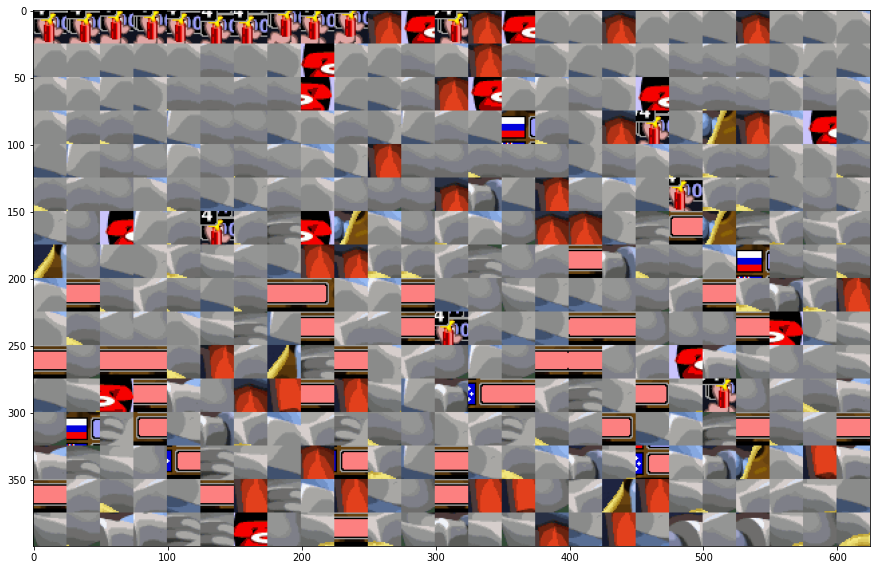

In [16]:
np.shape(topim)
plt.figure(figsize=(15,15))
plt.imshow(np.vstack([np.concatenate(topim[i:i+25], axis=1) for i in range(0, len(topim), 25)]))